In [1]:
# imports
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
from sklearn.model_selection import train_test_split,cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ValidationCurveDisplay

# Data loading and exploration

In [2]:
data = sns.load_dataset("titanic")

In [3]:
print(data.head(n=10))
print(data.info())

   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes

In [4]:
# With this command, we can see that there are some missing values. 177/891 missing values for age, and 688/891 for deck
data.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 720x432 with 0 Axes>

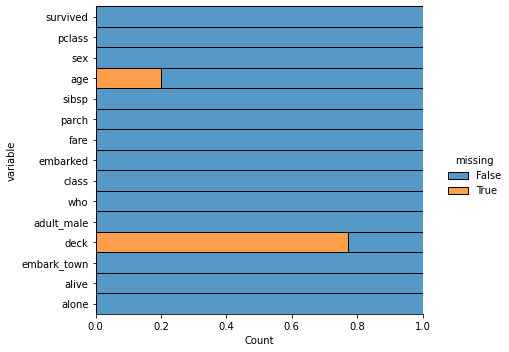

In [5]:
# Now we can see those same missing values in a seaborn heatmap
plt.figure(figsize=(10,6))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

In [6]:
# By checking
data.info()
# It is possible to see that the variables 
# [sex, embarked, class, who, adult_male, deck, embark_town, alive, alone] are either categorical, or at least, non-numerical
# There are two boolean variables, 2 categorical, and 5 object type variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


<Axes: xlabel='sex', ylabel='count'>

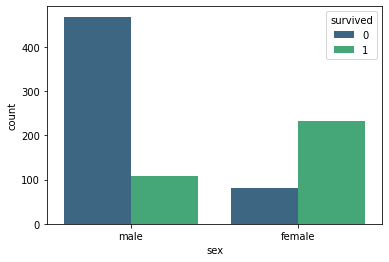

In [7]:
# Did more men or women survive the Titanic?
sns.countplot(x="sex", data=data, palette="viridis", hue="survived")
# It can be seen that more women survived than men

<Axes: xlabel='class', ylabel='count'>

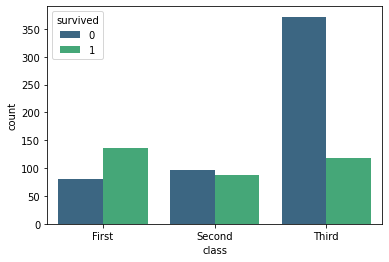

In [8]:
# Which passenger class was more likely to survive?
sns.countplot(x="class", data=data, palette="viridis", hue="survived")

In [9]:
# I believe that the plot is clear enough, but we can look at percentages:
data.groupby(["class"])['survived'].value_counts(normalize=True) * 100
# It can be seen that the class with the highest survival chance is the first class, 
#followed by the second class, and the third class most of its members died

class   survived
First   1           62.962963
        0           37.037037
Second  0           52.717391
        1           47.282609
Third   0           75.763747
        1           24.236253
Name: proportion, dtype: float64

<Axes: xlabel='fare', ylabel='Count'>

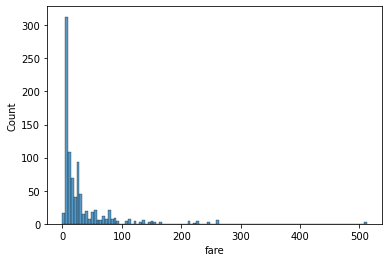

In [10]:
# What is the distribution of fare?
sns.histplot(data=data, x="fare")
# It can be seen that the fares are normally distributed with a heavy bias to the left. the cheapest fares are the most common,
# with the more expensive fares being less common. This makes sense. 

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     714 non-null    int64   
 1   pclass       714 non-null    int64   
 2   sex          714 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        714 non-null    int64   
 5   parch        714 non-null    int64   
 6   fare         714 non-null    float64 
 7   embarked     712 non-null    object  
 8   class        714 non-null    category
 9   who          714 non-null    object  
 10  adult_male   714 non-null    bool    
 11  deck         184 non-null    category
 12  embark_town  712 non-null    object  
 13  alive        714 non-null    object  
 14  alone        714 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 70.2+ KB
None


<Axes: xlabel='age', ylabel='Count'>

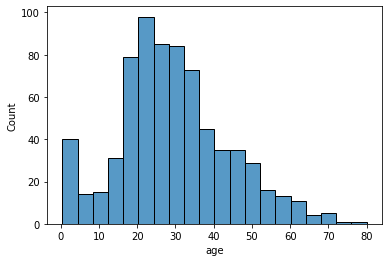

In [11]:
# What does the distribution of non-null age values look like?
data_clean = data.dropna(subset=["age"]).copy()
print(data_clean.info())
sns.histplot(data_clean, x="age")

<Axes: xlabel='age', ylabel='pclass'>

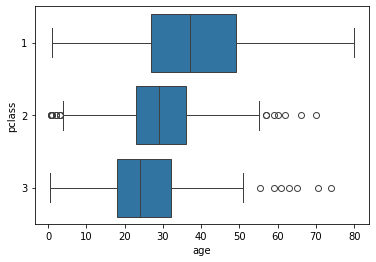

In [12]:
# What is the median age of each passenger class (pclass)? Visualize this in a box plot
data_clean = data.copy()
median_ages = data_clean.groupby(['pclass'])["age"].mean().reset_index()[['pclass', 'age']]
data_clean["pclass"] = data_clean["pclass"].astype("category")
sns.boxplot(data=data_clean, x="age", y="pclass")

# Data Cleansing

In [13]:
# NAN values in deck are dropped.
data_clean = data.drop(["deck"], axis=1).copy()

In [14]:
data_clean["age"] = data_clean.apply(lambda row: median_ages[median_ages.pclass == row["pclass"]]["age"].values[0] if np.isnan(row["age"]) else row["age"], axis=1)

In [15]:
data_clean.age.isna().value_counts()

age
False    891
Name: count, dtype: int64

In [16]:
# Now every other missing value is dropped
data_clean = data_clean.dropna().copy()

In [17]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     889 non-null    int64   
 1   pclass       889 non-null    int64   
 2   sex          889 non-null    object  
 3   age          889 non-null    float64 
 4   sibsp        889 non-null    int64   
 5   parch        889 non-null    int64   
 6   fare         889 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        889 non-null    category
 9   who          889 non-null    object  
 10  adult_male   889 non-null    bool    
 11  embark_town  889 non-null    object  
 12  alive        889 non-null    object  
 13  alone        889 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 86.1+ KB


In [18]:
# Some columns are duplicated or dependent from other columns. Some of these are "who" and "adult_male". They will be explored
# and removed
data_clean.head(n=10)
# With their names, we can see that who and adult_male are dependent on the sex of the passenger, as well as their age, where
# adult_male is a bollean if the sex is male, and the age is over a specific threshold.
# who is also dependent on the age and sex. if the age is below a threshold, the who is a child
# if it is over that threshold, then it depends on whether they are male or female, so they are man or woman

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.00000,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.00000,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.00000,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.00000,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.00000,0,0,8.0500,S,Third,man,True,Southampton,no,True
5,0,3,male,25.14062,0,0,8.4583,Q,Third,man,True,Queenstown,no,True
6,0,1,male,54.00000,0,0,51.8625,S,First,man,True,Southampton,no,True
7,0,3,male,2.00000,3,1,21.0750,S,Third,child,False,Southampton,no,False
8,1,3,female,27.00000,0,2,11.1333,S,Third,woman,False,Southampton,yes,False
9,1,2,female,14.00000,1,0,30.0708,C,Second,child,False,Cherbourg,yes,False


In [19]:
# We can confirm this by using some filters
data_clean[data_clean["age"] > 16][["sex","age","who","adult_male"]]

,sex,age,who,adult_male
0,male,22.00000,man,True
1,female,38.00000,woman,False
2,female,26.00000,woman,False
3,female,35.00000,woman,False
4,male,35.00000,man,True
...,...,...,...,...
886,male,27.00000,man,True
887,female,19.00000,woman,False
888,female,25.14062,woman,False
889,male,26.00000,man,True


In [20]:
data_clean[data_clean["age"] < 16][["sex","age","who","adult_male"]]

,sex,age,who,adult_male
7,male,2.00,child,False
9,female,14.00,child,False
10,female,4.00,child,False
14,female,14.00,child,False
16,male,2.00,child,False
...,...,...,...,...
831,male,0.83,child,False
850,male,4.00,child,False
852,female,9.00,child,False
869,male,4.00,child,False


It can be seen that the threshold that was previously discussed is 16.
Anything below 16 is considered a child, while anything above 16 is considered an adult. If they are above 16, and a male, then they are an adult male

In [21]:
data_clean[(data_clean["age"] > 16) & (data_clean["sex"] == "male")][["sex","age","who","adult_male"]]

,sex,age,who,adult_male
0,male,22.00000,man,True
4,male,35.00000,man,True
5,male,25.14062,man,True
6,male,54.00000,man,True
12,male,20.00000,man,True
...,...,...,...,...
883,male,28.00000,man,True
884,male,25.00000,man,True
886,male,27.00000,man,True
889,male,26.00000,man,True


In [22]:
# Now the categories can be deleted
data_clean = data_clean.drop(["who", "adult_male", "alive", "class", "embarked"],axis=1).copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   age          889 non-null    float64
 4   sibsp        889 non-null    int64  
 5   parch        889 non-null    int64  
 6   fare         889 non-null    float64
 7   embark_town  889 non-null    object 
 8   alone        889 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 63.4+ KB


In [23]:
# Now categorical columns are turned to numeric using get_dummies. 
data_clean = pd.get_dummies(data=data_clean, columns=["sex", "embark_town", "alone"], drop_first=False).copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 889 non-null    int64  
 1   pclass                   889 non-null    int64  
 2   age                      889 non-null    float64
 3   sibsp                    889 non-null    int64  
 4   parch                    889 non-null    int64  
 5   fare                     889 non-null    float64
 6   sex_female               889 non-null    bool   
 7   sex_male                 889 non-null    bool   
 8   embark_town_Cherbourg    889 non-null    bool   
 9   embark_town_Queenstown   889 non-null    bool   
 10  embark_town_Southampton  889 non-null    bool   
 11  alone_False              889 non-null    bool   
 12  alone_True               889 non-null    bool   
dtypes: bool(7), float64(2), int64(4)
memory usage: 54.7 KB


In [24]:
features = data_clean.drop(["survived"], axis=1).copy()

In [25]:
target = data_clean["survived"].copy()

In [26]:
# Data is split for training and testing. 20% for testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Model Training

## Logistic Regression

In [27]:
log_reg = LogisticRegression(random_state=0, max_iter=1000)

In [28]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [29]:
log_predicted = log_reg.predict(X_test)

In [30]:
# Classification report
target_names = ["Survived", "Did not survive"]
print(classification_report(y_test, log_predicted, target_names=target_names))

                 precision    recall  f1-score   support

       Survived       0.87      0.83      0.85       109
Did not survive       0.74      0.80      0.77        69

       accuracy                           0.81       178
      macro avg       0.80      0.81      0.81       178
   weighted avg       0.82      0.81      0.82       178



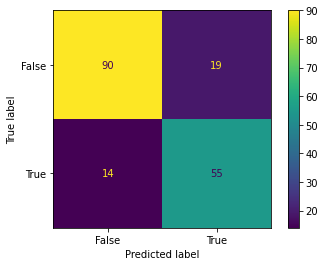

In [31]:
# Confusion Matrix
log_conf_mat = confusion_matrix(y_test, log_predicted)
tn, fp, fn, tp = log_conf_mat.ravel()
conf_mat_plot = ConfusionMatrixDisplay(confusion_matrix = log_conf_mat, display_labels = [False, True])

conf_mat_plot.plot()
plt.show()

In [32]:
# Cross validation 
clean_log_reg = LogisticRegression(random_state=0, max_iter=1000)
log_y_pred_roc = cross_val_predict(clean_log_reg, X_train, y_train, cv=5)

In [33]:
fpr, tpr, thresholds = roc_curve(y_train, log_y_pred_roc)

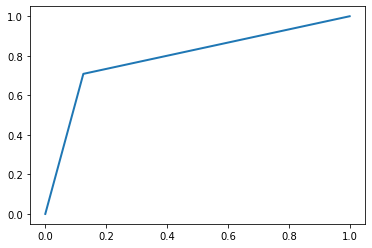

In [34]:
# Plot for ROC
plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [35]:
log_reg_roc_score = roc_auc_score(y_train, log_y_pred_roc)
log_reg_roc_score

0.7917435424354243

## SVC

In [36]:
svc_reg = SVC(gamma='auto', probability=True)

In [37]:
svc_reg.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [38]:
svc_predicted = svc_reg.predict(X_test)

In [39]:
# Classification report
target_names = ["Survived", "Did not survive"]
print(classification_report(y_test, svc_predicted, target_names=target_names))

                 precision    recall  f1-score   support

       Survived       0.80      0.79      0.79       109
Did not survive       0.67      0.68      0.68        69

       accuracy                           0.75       178
      macro avg       0.73      0.74      0.73       178
   weighted avg       0.75      0.75      0.75       178



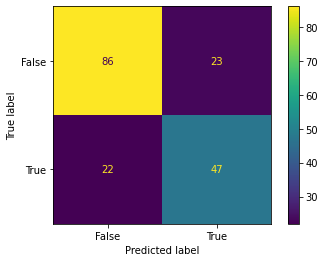

In [40]:
# Confusion Matrix
svc_conf_mat = confusion_matrix(y_test, svc_predicted)
tn, fp, fn, tp = svc_conf_mat.ravel()
conf_mat_plot = ConfusionMatrixDisplay(confusion_matrix = svc_conf_mat, display_labels = [False, True])

conf_mat_plot.plot()
plt.show()

In [41]:
# Cross validation 
clean_svc_reg = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svc_y_pred_roc = cross_val_predict(clean_svc_reg, X_train, y_train, cv=5)

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, svc_y_pred_roc)

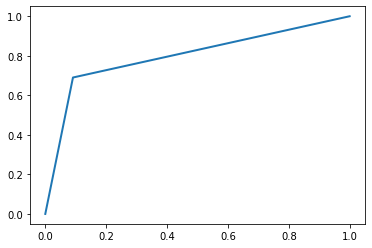

In [43]:
# Plot for ROC
plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [44]:
svc_reg_roc_score = roc_auc_score(y_train, svc_y_pred_roc)
svc_reg_roc_score

0.7995639047299564

## SGD

In [45]:
sgd_reg = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))

In [46]:
sgd_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [47]:
sgd_predicted = sgd_reg.predict(X_test)

In [48]:
# Classification report
target_names = ["Survived", "Did not survive"]
print(classification_report(y_test, sgd_predicted, target_names=target_names))

                 precision    recall  f1-score   support

       Survived       0.83      0.75      0.79       109
Did not survive       0.66      0.75      0.70        69

       accuracy                           0.75       178
      macro avg       0.74      0.75      0.75       178
   weighted avg       0.76      0.75      0.76       178



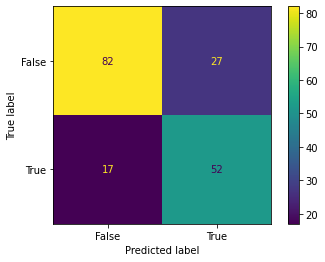

In [49]:
# Confusion Matrix
sgd_conf_mat = confusion_matrix(y_test, sgd_predicted)
tn, fp, fn, tp = sgd_conf_mat.ravel()
conf_mat_plot = ConfusionMatrixDisplay(confusion_matrix = sgd_conf_mat, display_labels = [False, True])

conf_mat_plot.plot()
plt.show()

In [50]:
# Cross validation 
clean_sgd_reg = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_y_pred_roc = cross_val_predict(clean_sgd_reg, X_train, y_train, cv=5, method="decision_function")

In [51]:
fpr, tpr, thresholds = roc_curve(y_train, sgd_y_pred_roc)

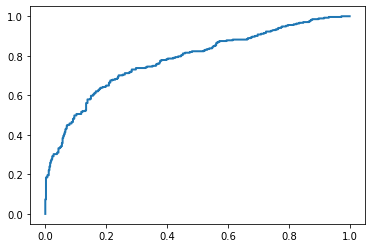

In [52]:
# Plot for ROC
plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [53]:
sgd_reg_roc_score = roc_auc_score(y_train, sgd_y_pred_roc)
sgd_reg_roc_score

0.7812520966118752

# Model Tuning

## SVC with scaling

In [54]:
# SVC requires scaling of the samples
svc_reg = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

In [55]:
svc_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [56]:
svc_predicted = svc_reg.predict(X_test)

In [57]:
# Classification report
target_names = ["Survived", "Did not survive"]
print(classification_report(y_test, svc_predicted, target_names=target_names))

                 precision    recall  f1-score   support

       Survived       0.85      0.85      0.85       109
Did not survive       0.77      0.77      0.77        69

       accuracy                           0.82       178
      macro avg       0.81      0.81      0.81       178
   weighted avg       0.82      0.82      0.82       178



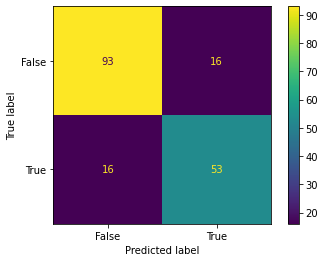

In [58]:
# Confusion Matrix
svc_conf_mat = confusion_matrix(y_test, svc_predicted)
tn, fp, fn, tp = svc_conf_mat.ravel()
conf_mat_plot = ConfusionMatrixDisplay(confusion_matrix = svc_conf_mat, display_labels = [False, True])

conf_mat_plot.plot()
plt.show()

In [59]:
# Cross validation 
clean_svc_reg = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svc_y_pred_roc = cross_val_predict(clean_svc_reg, X_train, y_train, cv=5)

In [60]:
fpr, tpr, thresholds = roc_curve(y_train, svc_y_pred_roc)

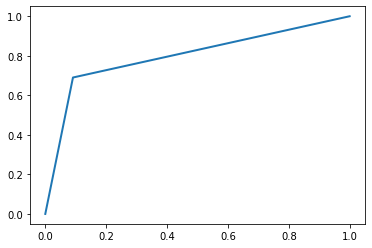

In [61]:
# Plot for ROC
plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [62]:
svc_reg_roc_score = roc_auc_score(y_train, svc_y_pred_roc)
svc_reg_roc_score

0.7995639047299564

## SVC Grid Search

In [63]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

In [64]:
parameters = {"svc__kernel":["rbf"], 
              "svc__gamma": [0.0001,0.001,0.01,0.1,1],
             "svc__C": [1,10,50,100,200,300]}

In [65]:
svc_gs = GridSearchCV(svc, parameters)
svc_gs

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'svc__C': [1, 10, 50, 100, 200, 300],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']})

In [66]:
svc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'svc__C': [1, 10, 50, 100, 200, 300],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']})

In [67]:
keys = svc_gs.cv_results_.keys()
test1_scores = svc_gs.cv_results_["mean_test_score"]
for key in keys:
    print(key)
    print(svc_gs.cv_results_[key])

mean_fit_time
[0.05029998 0.04542394 0.03925581 0.03913436 0.05844359 0.04524007
 0.04163036 0.03349729 0.03842936 0.06721177 0.04200196 0.04027119
 0.0440805  0.06013193 0.10603604 0.0425478  0.04583707 0.05830302
 0.07114882 0.13390536 0.03798304 0.04589925 0.07397008 0.11241426
 0.19830852 0.04020534 0.04493122 0.08779273 0.15773139 0.21385474]
std_fit_time
[0.00992417 0.00787267 0.00416686 0.00477407 0.00283543 0.00466238
 0.00956746 0.00052265 0.00133869 0.00853314 0.00385987 0.00512948
 0.0054466  0.01063652 0.03202301 0.00382066 0.00606287 0.00723349
 0.01648949 0.03842222 0.00464972 0.00720969 0.01144258 0.0237734
 0.06069286 0.00366586 0.00340961 0.00759669 0.04325818 0.07266032]
mean_score_time
[0.00459156 0.00439482 0.00393205 0.00344467 0.00635252 0.00426164
 0.00409174 0.00338006 0.00375781 0.00459418 0.00387988 0.00353675
 0.0036674  0.00409451 0.00458565 0.00342946 0.00414958 0.0040091
 0.00394711 0.00399504 0.00363173 0.00346341 0.00346837 0.00434704
 0.0038774  0.00362

In [68]:
# Test best model:
test_best_model, = np.where(svc_gs.cv_results_["rank_test_score"] == 1)[0]
test_best_params = svc_gs.cv_results_["params"][test_best_model]
print("Parameters of the best model")
print(test_best_params)
best_score = svc_gs.cv_results_["mean_test_score"][test_best_model]
print("Score of the best model")
print(best_score)

Parameters of the best model
{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Score of the best model
0.8312222988279327


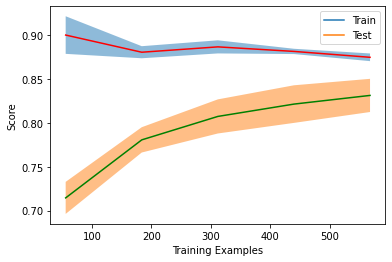

In [69]:
# Learning curve
clean_svc_reg = make_pipeline(StandardScaler(), SVC(gamma=0.1, probability=True, kernel="rbf", C=10))
train_sizes, train_scores, test_scores = learning_curve(clean_svc_reg, X_train, y_train)

display = LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
display.lines_[0].set_color("r")
display.lines_[1].set_color("g")
display.ax_.set_xlabel("Training Examples")
display.ax_.set_ylabel("Score")
plt.show()

From the learning curve, we can see that the training and testing scores seem to "converge" the more training examples there are. 
It can also be observed that the training, at first, was severly overfitted, as it had a score of over 90%, which was reduced the more training examples were given to the model. 
The testing was the opposite, as the more examples the model received, the less overfittede it was, so the better it could deal with unknown samples, such as the testing. 